"""
Using the 'Amazon Fine Food Reviews' Dataset from Kaggle, construct three
models as described below.

1.      Predict the helpfulness of the review.

2.      Predict the score the user assigned an item.

3.      Predict the responsiveness of a review.

Resources:
https://www.kaggle.com/snap/amazon-fine-food-reviews

"""

## Preliminaries

In [1]:
import pandas as pd
import numpy as np
import datetime
import string
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import linear_model
from sklearn import metrics, cross_validation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

/Users/stellaxu/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# load the reviews csv file
reviews = pd.DataFrame.from_csv('Reviews.csv', index_col=None)

In [4]:
# convert the time format provided into a nice pythonic datetime
reviews['Time'] = pd.to_datetime(reviews['Time'], unit='s')

In [5]:
# This is a measure of the helpfulness of a review that you are to predict.
reviews['Helpfulness'] = (reviews['HelpfulnessNumerator'] + 1) / (reviews['HelpfulnessDenominator'] + 2)

# A review is considered response-generating if at least 5 people have said it was helpful or not
reviews['Responsiveness'] = reviews['HelpfulnessDenominator'] >= 5

In [6]:
reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpfulness,Responsiveness
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,0.666667,False
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0.500000,False
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...,0.666667,False
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...,0.800000,False
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,2012-10-21,Great taffy,Great taffy at a great price. There was a wid...,0.500000,False


In [7]:
# Calculate the length of the Text
Text_len = np.array([0]*len(reviews))
for i in range(len(reviews)):
    Text_len[i] = len(reviews['Text'].iloc[i].split())

In [8]:
reviews['TextLength'] = pd.DataFrame(Text_len)

In [9]:
reviews = reviews[reviews['Helpfulness'] <= 1]

In [10]:
# no data should be trained on from June 1, 2012 and onward
train_cutoff = datetime.datetime(2012,6,1).date()

In [11]:
# separate data into training and test
# length of train_data = 468416
# length of test_data = 100037
train_data = reviews[reviews['Time'] < train_cutoff]
test_data = reviews[reviews['Time'] >= train_cutoff]

In [12]:
# sub-sample dataset
ratio = len(train_data)/float(len(test_data))
train_size = 50000
test_size = np.int(train_size/ratio)

validation_data = train_data.iloc[train_size:(train_size+test_size)]
train_data = train_data.iloc[:train_size]
test_data = test_data.iloc[:test_size]

In [13]:
## create useful predictors and responses
# Training set
X_summary_train = train_data[['Summary']]
X_text_train = train_data[['Text']]
Y_helpful_train = train_data[['Helpfulness']]
Y_score_train = train_data[['Score']]
Y_respon_train = train_data[['Responsiveness']]

# Validation set
X_summary_val = validation_data[['Summary']]
X_text_val = validation_data[['Text']]
Y_helpful_val = validation_data[['Helpfulness']]
Y_score_val = validation_data[['Score']]
Y_respon_val = validation_data[['Responsiveness']]

# Test set
X_summary_test = test_data[['Summary']]
X_text_test = test_data[['Text']]
Y_helpful_test = test_data[['Helpfulness']]
Y_score_test = test_data[['Score']]
Y_respon_test = test_data[['Responsiveness']]

## Choose predictors for each response

### Distribution of response

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a26f18b00>]], dtype=object)

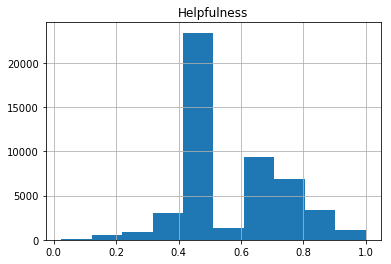

In [14]:
pd.DataFrame.hist(train_data[['Helpfulness']])

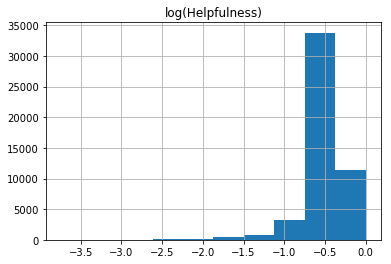

In [15]:
pd.DataFrame.hist(np.log(train_data[['Helpfulness']]))
plt.title("log(Helpfulness)")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a0b9a5128>]], dtype=object)

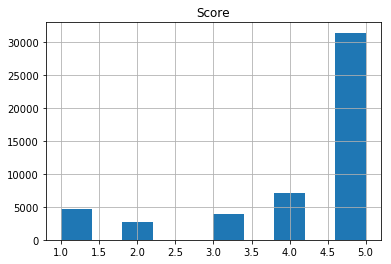

In [16]:
pd.DataFrame.hist(train_data[['Score']])

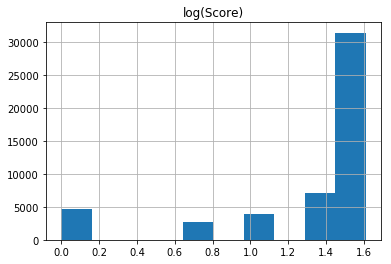

In [17]:
pd.DataFrame.hist(np.log(train_data[['Score']]))
plt.title("log(Score)")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a139d3748>]], dtype=object)

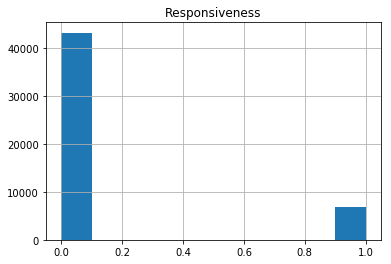

In [18]:
pd.DataFrame.hist(train_data[['Responsiveness']])

### Correlations

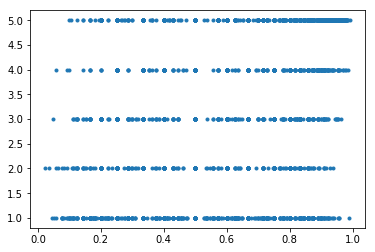

In [19]:
plt.plot(reviews['Helpfulness'].iloc[:20000], reviews['Score'].iloc[:20000],".")

In [20]:
np.corrcoef(reviews['Helpfulness'], reviews['Score'])

array([[ 1.        ,  0.17778093],
       [ 0.17778093,  1.        ]])

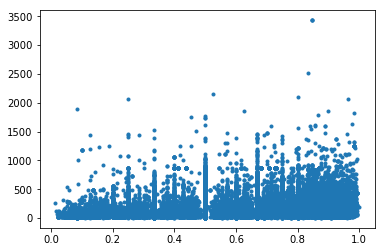

In [21]:
plt.plot(reviews['Helpfulness'], reviews['TextLength'],".")

In [22]:
np.corrcoef(reviews['Helpfulness'], reviews['TextLength'])

array([[ 1.        ,  0.13749464],
       [ 0.13749464,  1.        ]])

In [23]:
np.corrcoef(reviews['Helpfulness'], reviews['HelpfulnessDenominator'])

array([[ 1.        ,  0.24773578],
       [ 0.24773578,  1.        ]])

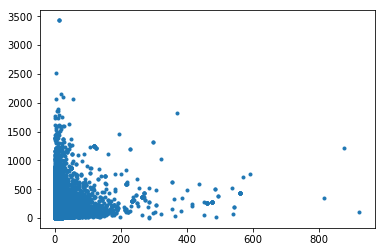

In [24]:
plt.plot(reviews['HelpfulnessDenominator'], reviews['TextLength'],".")

In [25]:
np.corrcoef(reviews['TextLength'], reviews['HelpfulnessDenominator'])

array([[ 1.        ,  0.17319842],
       [ 0.17319842,  1.        ]])

### Conclusion

1. Response: Helpfulness
   Response type: continuous
   Method: regression
   Predictors: Summary, Text length, Score

2. Response: Score
   Response type: 5 classes
   Method: classification
   Predictors: Summary

3. Response: Responsiveness
   Response type: 2 classes, True/False
   Method: classification
   Predictors: Summary, (Text length)
   
Remark: We have heavily imbalanced samples. Responses like 'Score' and 'Responsiveness' are highly skewed. 

## Data Cleaning

### Bag of Words

In [26]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
stemmer = PorterStemmer()

In [27]:
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

In [28]:
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return ' '.join(stems)

In [33]:
#from string import maketrans

intab = string.punctuation
outtab = "                                "
trantab = str.maketrans(intab, outtab)

In [34]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [38]:
## Training set
summary_train_corpus = []
for text in X_summary_train['Summary']:
    if type(text)==float:
        text = str(text)
    text = text.lower()
    text = text.translate(trantab)
    text = tokenize(text)
    summary_train_corpus.append(text)

In [39]:
count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()

summary_train_counts = count_vect.fit_transform(summary_train_corpus)        
summary_train_tfidf = tfidf_transformer.fit_transform(summary_train_counts)

In [40]:
# text_train_corpus = []
# for text in X_text_train['Text']:
#     if type(text)==float:
#         text = str(text)
#     text = text.lower()
#     text = text.translate(trantab)
#     text = text.decode("utf8")
#     text = tokenize(text)
#     text_train_corpus.append(text)

In [41]:
# text_train_counts = count_vect.fit_transform(text_train_corpus)        
# text_train_tfidf = tfidf_transformer.fit_transform(text_train_counts)

In [44]:
## Validation set
summary_val_corpus = []
for text in X_summary_val['Summary']:
    if type(text)==float:
        text = str(text)
    text = text.lower()
    text = text.translate(trantab)
    text = tokenize(text)
    summary_val_corpus.append(text)

In [45]:
summary_val_counts = count_vect.transform(summary_val_corpus)        
summary_val_tfidf = tfidf_transformer.transform(summary_val_counts)

In [47]:
## Test set
summary_test_corpus = []
for text in X_summary_test['Summary']:
    if type(text)==float:
        text = str(text)
    text = text.lower()
    text = text.translate(trantab)
    text = tokenize(text)
    summary_test_corpus.append(text)

In [48]:
summary_test_counts = count_vect.transform(summary_test_corpus)
summary_test_tfidf = tfidf_transformer.transform(summary_test_counts)

In [49]:
# text_test_corpus = []
# for text in X_text_test['Text']:
#     if type(text)==float:
#         text = str(text)
#     text = text.lower()
#     text = text.translate(trantab)
#     text = text.decode("utf8")
#     text = tokenize(text)
#     text_test_corpus.append(text)

In [50]:
# text_test_counts = count_vect.fit_transform(text_test_corpus)        
# text_test_tfidf = tfidf_transformer.fit_transform(text_test_counts)

### Latent Dirichlet Allocation

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

n_samples = 2000
n_features = 1000
n_topics = 10
n_top_words = 20

In [52]:
lda = LatentDirichletAllocation(n_topics=n_topics, 
                                max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

In [53]:
lda.fit(summary_train_counts)

/Users/stellaxu/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=10, n_jobs=1, n_topics=10, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [54]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [55]:
print("\nTopics in LDA model:")
tf_feature_names = count_vect.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model:
Topic #0:
love coffe these tasti thi stuff wonder mix work drink disappoint addict up bread ship wow smooth lover bewar roast
Topic #1:
good not dog for yummi as my bad cooki me healthi food low more eat happi chew carb calori honey
Topic #2:
the best excel snack ever awesom nice chip bar have organ ve tri rice real there natur oil cereal salti
Topic #3:
tea is thi you on can all at be if make your fantast review go packag will money other soup
Topic #4:
product great with sweet and for perfect free candi ok gluten our nut dark fresh ha chicken jerki noodl noth
Topic #5:
delici so are easi use onli water absolut super ingredi vanilla far we quick aw pasta could season pure cheaper
Topic #6:
it tast like great not buy realli from don popcorn amazon wa gummi high do bear butter coconut worth smell
Topic #7:
to in the of treat no just yum what cup amaz green hot get made expect altern hard sauc servic
Topic #8:
great my flavor for cat price love food favorit too bett

In [56]:
doc_topic_train = lda.transform(summary_train_counts)

In [57]:
lda.fit(summary_test_counts)

/Users/stellaxu/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=10, n_jobs=1, n_topics=10, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [58]:
doc_topic_test = lda.transform(summary_test_counts)

In [59]:
lda.fit(summary_val_counts)

/Users/stellaxu/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=10, n_jobs=1, n_topics=10, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [60]:
doc_topic_val = lda.transform(summary_val_counts)

## Statistical Modeling

## Problem 1

In [48]:
prediction = dict()
probability = dict()
MSE_q1 = dict()
R_square_q1 = dict()

### Model 1 - Linear Regression with 'Score' and 'TextLength'

In [49]:
linearreg = linear_model.LinearRegression()
linearreg.fit(train_data[['Score','TextLength']], Y_helpful_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [50]:
prediction['Linear'] = linearreg.predict(validation_data[['Score','TextLength']])

In [51]:
# Mean Square Error
MSE_q1['Linear1'] = mean_squared_error(Y_helpful_val, prediction['Linear'])

In [52]:
# Training R-square
R_square_q1['Linear1'] = linearreg.score(train_data[['Score','TextLength']], Y_helpful_train)

### Model 2 - Linear Regression with 'Summary' added

In [53]:
residuals_train = Y_helpful_train-linearreg.predict(train_data[['Score','TextLength']])

In [54]:
linearreg2 = linear_model.LinearRegression()
linearreg2.fit(summary_train_tfidf, residuals_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [55]:
prediction['Linear2'] = linearreg2.predict(summary_val_tfidf)

In [56]:
# Mean Square Error
MSE_q1['Linear2'] = mean_squared_error(Y_helpful_val, prediction['Linear2']+prediction['Linear'])

In [57]:
# Training R-square
R_square_q1['Linear2'] = 'NA'

### Model 3 - Only include 'Summary'

In [58]:
linearreg3 = linear_model.LinearRegression()
linearreg3.fit(summary_train_tfidf, Y_helpful_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [59]:
prediction['Linear3'] = linearreg3.predict(summary_val_tfidf)

In [60]:
# Mean Square Error
MSE_q1['Linear3'] = mean_squared_error(Y_helpful_val, prediction['Linear3'])

In [61]:
# Training R-square
R_square_q1['Linear3'] = linearreg3.score(summary_train_tfidf, Y_helpful_train)

### Model 4 - Random Forest

In [62]:
rf = RandomForestRegressor(n_jobs=2, max_depth=50, n_estimators=100)
mod = rf.fit(summary_train_tfidf, Y_helpful_train)

/Users/yuemingxu/Documents/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


In [63]:
prediction['Random_Forest_q1'] = mod.predict(summary_val_tfidf)

In [64]:
# Mean Square Error
MSE_q1['Random Forest'] = mean_squared_error(Y_helpful_val, prediction['Random_Forest_q1'])

In [65]:
# Training R-square
R_square_q1['Random Forest'] = rf.score(summary_train_tfidf, Y_helpful_train)

### Model 5 - Lasso Regression

In [66]:
lasso = linear_model.Lasso(alpha=0.001)
lasso.fit(summary_train_tfidf, Y_helpful_train)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [67]:
prediction['Lasso_q1'] = lasso.predict(summary_val_tfidf)

In [68]:
# Mean Square Error
MSE_q1['Lasso'] = mean_squared_error(prediction['Lasso_q1'], Y_helpful_val)

In [69]:
# Training R-square
R_square_q1['Lasso'] = lasso.score(summary_train_tfidf, Y_helpful_train)

### Model Selection

#### Mean Square Error

In [71]:
MSE_q1

{'Lasso': 0.025286337663471905,
 'Linear1': 0.02386663067989743,
 'Linear2': 0.026593360296286582,
 'Linear3': 0.027566664713877882,
 'Random Forest': 0.024443561678703395}

#### In-sample R-square

In [72]:
R_square_q1

{'Lasso': 0.0,
 'Linear1': 0.056823195683534229,
 'Linear2': 'NA',
 'Linear3': 0.24041171483298684,
 'Random Forest': 0.18782781862890563}

#### Residual vs Fitted Value

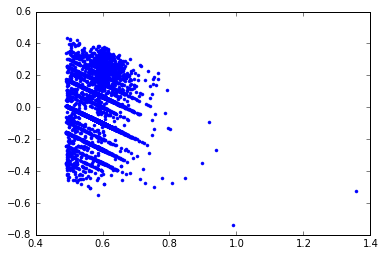

In [73]:
# Linear 1
residuals_val = Y_helpful_val-prediction['Linear']
plt.plot(prediction['Linear'], residuals_val, '.')

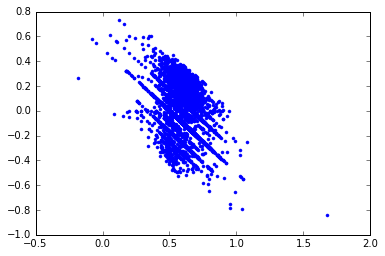

In [74]:
# Linear 2
residuals_val2 = Y_helpful_val-prediction['Linear']-prediction['Linear2']
plt.plot(prediction['Linear']+prediction['Linear2'], residuals_val2, '.')

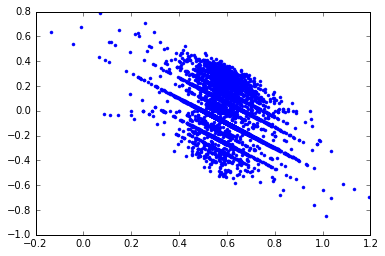

In [75]:
# Linear 3
residuals_val3 = Y_helpful_val-prediction['Linear3']
plt.plot(prediction['Linear3'], residuals_val3, '.')

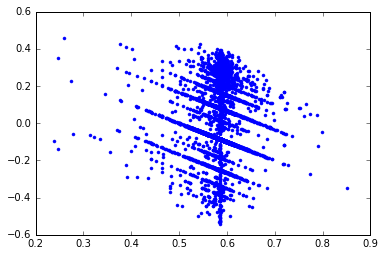

In [76]:
# Random Forest
plt.plot(prediction['Random_Forest_q1'], 
         Y_helpful_val['HelpfulnessHH']-prediction['Random_Forest_q1'], 
         '.')

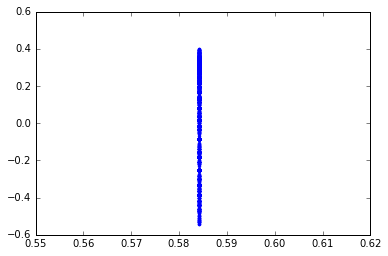

In [77]:
# Lasso Regression
plt.plot(prediction['Lasso_q1'], Y_helpful_val['HelpfulnessHH']-prediction['Lasso_q1'], '.')

#### Conclusion: I select Model 1 - Linear Regression with 'Text Length' and 'Score'.

### Prediction

In [79]:
Final_predict = linearreg.predict(test_data[['Score','TextLength']])

In [80]:
Final_predict

array([[ 0.49545232],
       [ 0.58745255],
       [ 0.5780192 ],
       ..., 
       [ 0.64320272],
       [ 0.61150262],
       [ 0.58837756]])

## Problem 2

In [81]:
Miss_train_q2 = dict()
Miss_val_q2 = dict()

### Model 1 - Logisitic Regression with L2 penalty - unbalanced

In [82]:
logreg_q2 = linear_model.LogisticRegression(C=1e5)
logreg_q2.fit(summary_train_tfidf, Y_score_train)

/Users/yuemingxu/Documents/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [83]:
prediction['Logistic_unbal_q2'] = logreg_q2.predict(summary_val_tfidf)
probability['Logistic_unbal_q2'] = logreg_q2.predict_proba(summary_val_tfidf)

In [84]:
Miss_val_q2['Mod1'] = sum(Y_score_val['Score']!=prediction['Logistic_unbal_q2'])/float(len(Y_score_val))

In [85]:
Miss_train_q2['Mod1'] = sum(Y_score_train['Score']!=logreg_q2.predict(summary_train_tfidf))/float(len(Y_score_train))

### Model 2 - Logsitic Regression with L2 penalty - balanced

In [86]:
logreg_bal_q2 = linear_model.LogisticRegression(C=1e5, class_weight='balanced')
logreg_bal_q2.fit(summary_train_tfidf, Y_score_train)

LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [87]:
prediction['Logistic_bal_q2'] = logreg_bal_q2.predict(summary_val_tfidf)
probability['Logistic_bal_q2'] = logreg_bal_q2.predict_proba(summary_val_tfidf)

In [88]:
Miss_val_q2['Mod2'] = sum(Y_score_val['Score']!=prediction['Logistic_bal_q2'])/float(len(Y_score_val))

In [89]:
Miss_train_q2['Mod2'] = sum(Y_score_train['Score']!=logreg_bal_q2.predict(summary_train_tfidf))/float(len(Y_score_train))

### Model 3 - Logsitic Regression with L1 penalty - unbalanced

In [90]:
logreg_lasso_q2 = linear_model.LogisticRegression(C=1, penalty='l1')
logreg_lasso_q2.fit(summary_train_tfidf, Y_score_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [91]:
prediction['Logistic_lasso_unbal_q2'] = logreg_lasso_q2.predict(summary_val_tfidf)
probability['Logistic_lasso_unbal_q2'] = logreg_lasso_q2.predict_proba(summary_val_tfidf)

In [92]:
Miss_val_q2['Mod3'] = sum(Y_score_val['Score']!=prediction['Logistic_lasso_unbal_q2'])/float(len(Y_score_val))

In [93]:
Miss_train_q2['Mod3'] = sum(Y_score_train['Score']!=logreg_lasso_q2.predict(summary_train_tfidf))/float(len(Y_score_train))

### Model 4 - Logsitic Regression with L1 penalty - balanced

In [94]:
logreg_lasso_bal_q2 = linear_model.LogisticRegression(C=1, penalty='l1', class_weight='balanced')
logreg_lasso_bal_q2.fit(summary_train_tfidf, Y_score_train)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [95]:
prediction['Logistic_lasso_bal_q2'] = logreg_lasso_bal_q2.predict(summary_val_tfidf)
probability['Logistic_lasso_bal_q2'] = logreg_lasso_bal_q2.predict_proba(summary_val_tfidf)

In [96]:
Miss_val_q2['Mod4'] = sum(Y_score_val['Score']!=prediction['Logistic_lasso_bal_q2'])/float(len(Y_score_val))

In [97]:
Miss_train_q2['Mod4'] = sum(Y_score_train['Score']!=logreg_lasso_bal_q2.predict(summary_train_tfidf))/float(len(Y_score_train))

### Model 5 - Random Forest - unbalanced

In [98]:
rf_q2 = RandomForestClassifier(n_jobs=2, max_depth=50, n_estimators=100)
rf_q2.fit(summary_train_tfidf, Y_score_train)

/Users/yuemingxu/Documents/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=2, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [99]:
prediction['Random_Forest_q2'] = rf_q2.predict(summary_val_tfidf)
probability['Random_Forest_q2'] = rf_q2.predict_proba(summary_val_tfidf)

In [100]:
Miss_val_q2['Mod5'] = sum(Y_score_val['Score']!=prediction['Random_Forest_q2'])/float(len(Y_score_val))

In [101]:
Miss_train_q2['Mod5'] = sum(Y_score_train['Score']!=rf_q2.predict(summary_train_tfidf))/float(len(Y_score_train))

### Model 6 - Random Forest - balanced

In [102]:
rf_bal_q2 = RandomForestClassifier(n_jobs=2, max_depth=50, n_estimators=100, class_weight='balanced')
rf_bal_q2.fit(summary_train_tfidf, Y_score_train)

/Users/yuemingxu/Documents/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=50, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [103]:
prediction['Random_Forest_bal_q2'] = rf_bal_q2.predict(summary_val_tfidf)
probability['Random_Forest_bal_q2'] = rf_bal_q2.predict_proba(summary_val_tfidf)

In [104]:
Miss_val_q2['Mod6'] = sum(Y_score_val['Score']!=prediction['Random_Forest_bal_q2'])/float(len(Y_score_val))

In [105]:
Miss_train_q2['Mod6'] = sum(Y_score_train['Score']!=rf_bal_q2.predict(summary_train_tfidf))/float(len(Y_score_train))

### Model Selection

#### Misclassification Rate - Training set

In [106]:
Miss_train_q2

{'Mod1': 0.20888000000000001,
 'Mod2': 0.2311,
 'Mod3': 0.28016000000000002,
 'Mod4': 0.26748,
 'Mod5': 0.32190000000000002,
 'Mod6': 0.27942}

#### Misclassification Rate - Validation set

In [107]:
Miss_val_q2

{'Mod1': 0.33414497096834611,
 'Mod2': 0.36430043079228319,
 'Mod3': 0.31073234688143847,
 'Mod4': 0.33161640756696009,
 'Mod5': 0.36102266342011613,
 'Mod6': 0.42367484547668105}

#### Confusion Matrix

In [108]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(set(Y_score_val['Score'])))
    plt.xticks(tick_marks, set(Y_score_val['Score']))
    plt.yticks(tick_marks, set(Y_score_val['Score']))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 473   86   53   51  276]
 [ 146  130   86   52  179]
 [  94   85  234  140  322]
 [  70   56   99  317 1118]
 [ 120   57  123  355 5956]]


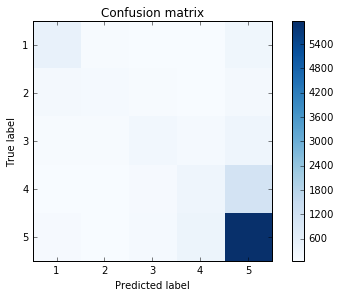

In [109]:
## Model 1
# Compute confusion matrix
cm = confusion_matrix(Y_score_val, prediction['Logistic_unbal_q2'])
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

Confusion matrix, with normalization
[[ 0.5   0.09  0.06  0.05  0.29]
 [ 0.25  0.22  0.15  0.09  0.3 ]
 [ 0.11  0.1   0.27  0.16  0.37]
 [ 0.04  0.03  0.06  0.19  0.67]
 [ 0.02  0.01  0.02  0.05  0.9 ]]


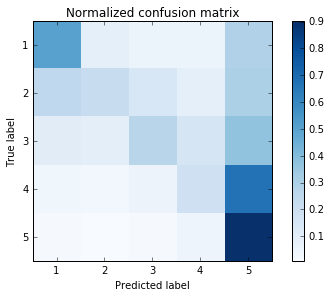

In [110]:
# Compute normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Confusion matrix, with normalization')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

Confusion matrix, without normalization
[[ 488  157   56   48  190]
 [ 137  207   92   53  104]
 [  92  161  288  148  186]
 [  84  114  171  495  796]
 [ 175  198  268  660 5310]]


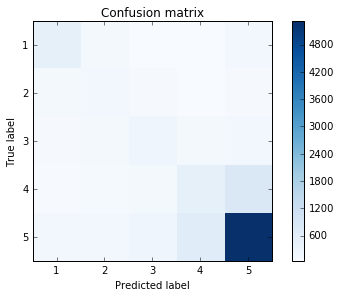

In [111]:
## Model 2
# Compute confusion matrix
cm = confusion_matrix(Y_score_val, prediction['Logistic_bal_q2'])
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

Confusion matrix, with normalization
[[ 0.52  0.17  0.06  0.05  0.2 ]
 [ 0.23  0.35  0.16  0.09  0.18]
 [ 0.11  0.18  0.33  0.17  0.21]
 [ 0.05  0.07  0.1   0.3   0.48]
 [ 0.03  0.03  0.04  0.1   0.8 ]]


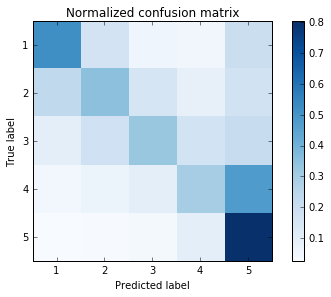

In [112]:
# Compute normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Confusion matrix, with normalization')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

Confusion matrix, without normalization
[[ 467   40   39   25  368]
 [ 148   94   66   23  262]
 [ 104   59  188  117  407]
 [  46   28   77  212 1297]
 [  65   12   45   90 6399]]


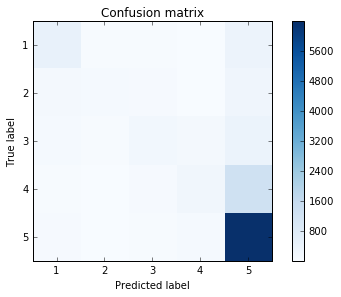

In [113]:
## Model 3
# Compute confusion matrix
cm = confusion_matrix(Y_score_val, prediction['Logistic_lasso_unbal_q2'])
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

Confusion matrix, with normalization
[[ 0.5   0.04  0.04  0.03  0.39]
 [ 0.25  0.16  0.11  0.04  0.44]
 [ 0.12  0.07  0.21  0.13  0.47]
 [ 0.03  0.02  0.05  0.13  0.78]
 [ 0.01  0.    0.01  0.01  0.97]]


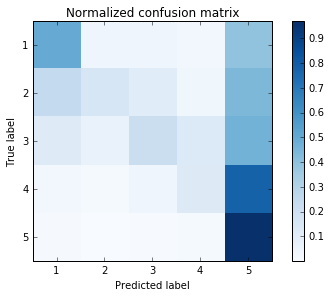

In [114]:
# Compute normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Confusion matrix, with normalization')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

Confusion matrix, without normalization
[[ 536  143   53   29  178]
 [ 153  217   87   37   99]
 [ 104  169  282  113  207]
 [  74   91  185  407  903]
 [ 169  144  206  397 5695]]


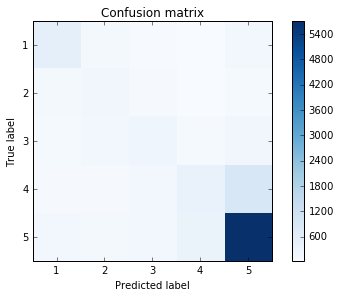

In [115]:
## Model 4
# Compute confusion matrix
cm = confusion_matrix(Y_score_val, prediction['Logistic_lasso_bal_q2'])
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

Confusion matrix, with normalization
[[ 0.57  0.15  0.06  0.03  0.19]
 [ 0.26  0.37  0.15  0.06  0.17]
 [ 0.12  0.19  0.32  0.13  0.24]
 [ 0.04  0.05  0.11  0.25  0.54]
 [ 0.03  0.02  0.03  0.06  0.86]]


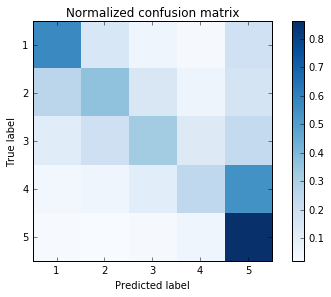

In [116]:
# Compute normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Confusion matrix, with normalization')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

Confusion matrix, without normalization
[[ 109    1    2    2  825]
 [  18    3    9    0  563]
 [   6    0   70   24  775]
 [   0    0   15   41 1604]
 [   4    0    1    6 6600]]


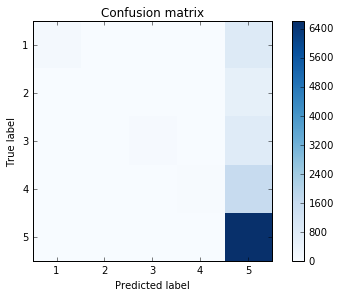

In [117]:
## Model 5
# Compute confusion matrix
cm = confusion_matrix(Y_score_val, prediction['Random_Forest_q2'])
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

Confusion matrix, with normalization
[[  1.16e-01   1.06e-03   2.13e-03   2.13e-03   8.79e-01]
 [  3.04e-02   5.06e-03   1.52e-02   0.00e+00   9.49e-01]
 [  6.86e-03   0.00e+00   8.00e-02   2.74e-02   8.86e-01]
 [  0.00e+00   0.00e+00   9.04e-03   2.47e-02   9.66e-01]
 [  6.05e-04   0.00e+00   1.51e-04   9.08e-04   9.98e-01]]


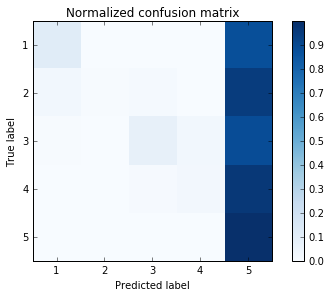

In [118]:
# Compute normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Confusion matrix, with normalization')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

Confusion matrix, without normalization
[[ 633  162   44   21   79]
 [ 209  227   75   27   55]
 [ 218  132  286  130  109]
 [ 310   56  175  505  614]
 [1212  109  126  661 4503]]


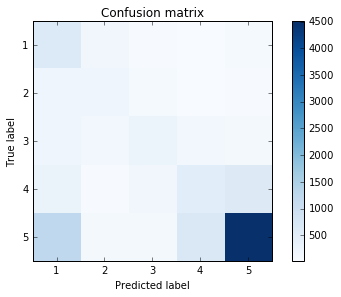

In [119]:
## Model 6
# Compute confusion matrix
cm = confusion_matrix(Y_score_val, prediction['Random_Forest_bal_q2'])
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

Confusion matrix, with normalization
[[ 0.67  0.17  0.05  0.02  0.08]
 [ 0.35  0.38  0.13  0.05  0.09]
 [ 0.25  0.15  0.33  0.15  0.12]
 [ 0.19  0.03  0.11  0.3   0.37]
 [ 0.18  0.02  0.02  0.1   0.68]]


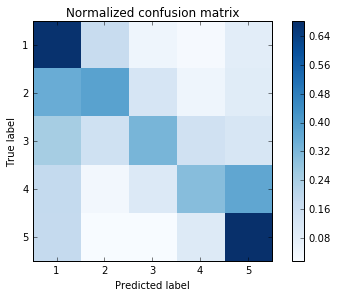

In [120]:
# Compute normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Confusion matrix, with normalization')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

#### ROC Plot

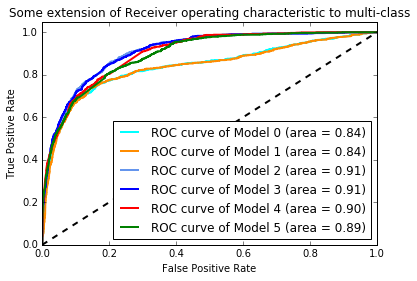

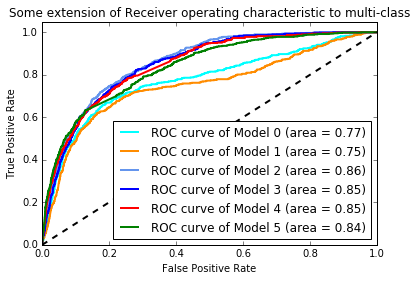

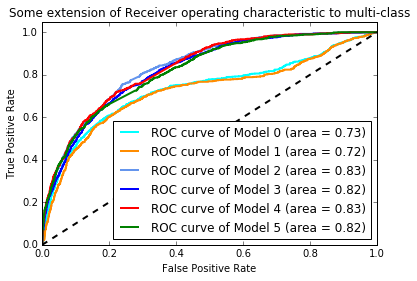

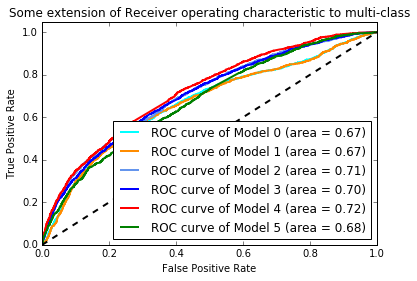

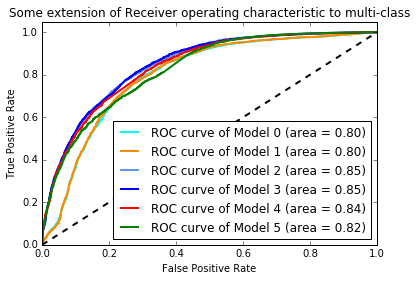

In [126]:
from itertools import cycle
from sklearn.preprocessing import label_binarize
y_test = Y_score_val['Score']
y_test = label_binarize(y_test, classes=[1,2,3,4,5])
y_score1 = probability['Logistic_unbal_q2']
y_score2 = probability['Logistic_bal_q2']
y_score3 = probability['Logistic_lasso_unbal_q2']
y_score4 = probability['Logistic_lasso_bal_q2']
y_score5 = probability['Random_Forest_q2']
y_score6 = probability['Random_Forest_bal_q2']

fpr = dict()
tpr = dict()
roc_auc = dict()
auc1 = dict()
auc1[0] = 0
auc1[1] = 0
auc1[2] = 0
auc1[3] = 0
auc1[4] = 0
auc1[5] = 0

for i in range(5):
    fpr[0], tpr[0], _ = roc_curve(y_test[:,i], y_score1[:,i])
    roc_auc[0] = auc(fpr[0], tpr[0])
    fpr[1], tpr[1], _ = roc_curve(y_test[:,i], y_score2[:,i])
    roc_auc[1] = auc(fpr[1], tpr[1])
    fpr[2], tpr[2], _ = roc_curve(y_test[:,i], y_score3[:,i])
    roc_auc[2] = auc(fpr[2], tpr[2])
    fpr[3], tpr[3], _ = roc_curve(y_test[:,i], y_score4[:,i])
    roc_auc[3] = auc(fpr[3], tpr[3])
    fpr[4], tpr[4], _ = roc_curve(y_test[:,i], y_score5[:,i])
    roc_auc[4] = auc(fpr[4], tpr[4])
    fpr[5], tpr[5], _ = roc_curve(y_test[:,i], y_score6[:,i])
    roc_auc[5] = auc(fpr[5], tpr[5])
    
    auc1[0] += roc_auc[0]
    auc1[1] += roc_auc[1]
    auc1[2] += roc_auc[2]
    auc1[3] += roc_auc[3]
    auc1[4] += roc_auc[4]
    auc1[5] += roc_auc[5]
    
    plt.figure()
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'blue', 'red', 'green'])
    lw=2
    for i, color in zip(range(6), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of Model {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

In [128]:
# AUC numbers
auc1

{0: 3.8115060060724124,
 1: 3.7734351459356299,
 2: 4.1536065097717421,
 3: 4.1295283040432373,
 4: 4.1367710225024403,
 5: 4.0494686183258954}

#### Conclusion: I select Model 3 - unbalanced Logsitic Regression with L1 penalty

### Prediction

In [129]:
Final_predict = logreg_lasso_q2.predict(summary_test_tfidf)

In [130]:
Final_predict

array([1, 5, 4, ..., 5, 5, 5])

In [131]:
# Misclassification Rate
sum(Y_score_test['Score']!=Final_predict)/float(len(Y_score_test))

0.31194980333395766

## Problem 3

In [132]:
Mis_train_q3 = dict()
Mis_val_q3 = dict()

### Model 1 - Logsitic Regression with L2 penalty - unbalanced

In [133]:
logreg_q3 = linear_model.LogisticRegression(C=1e5)
logreg_q3.fit(summary_train_tfidf, Y_respon_train)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [134]:
prediction['Logistic_q3'] = logreg_q3.predict(summary_val_tfidf)
probability['Logistic_q3'] = logreg_q3.predict_proba(summary_val_tfidf)

In [135]:
Mis_val_q3['Mod1'] = sum(Y_respon_val['ResponsivenessHH']!=prediction['Logistic_q3'])/float(len(Y_respon_val))

In [136]:
Mis_train_q3['Mod1'] = sum(Y_respon_train['ResponsivenessHH']!=logreg_q3.predict(summary_train_tfidf))/float(len(Y_respon_train))

### Model 2 - Logsitic Regression with L2 penalty - balanced

In [137]:
logreg_bal_q3 = linear_model.LogisticRegression(C=1e5, class_weight='balanced')
logreg_bal_q3.fit(summary_train_tfidf, Y_respon_train)

LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [138]:
prediction['Logistic_bal_q3'] = logreg_bal_q3.predict(summary_val_tfidf)
probability['Logistic_bal_q3'] = logreg_bal_q3.predict_proba(summary_val_tfidf)

In [139]:
Mis_val_q3['Mod2'] = sum(Y_respon_val['ResponsivenessHH']!=prediction['Logistic_bal_q3'])/float(len(Y_respon_val))

In [140]:
Mis_train_q3['Mod2'] = sum(Y_respon_train['ResponsivenessHH']!=logreg_bal_q3.predict(summary_train_tfidf))/float(len(Y_respon_train))

### Model 3 - Logsitic Regression with L1 penalty - unbalanced

In [141]:
logreg_lasso_q3 = linear_model.LogisticRegression(C=1e4, penalty='l1')
logreg_lasso_q3.fit(summary_train_tfidf, Y_respon_train)

LogisticRegression(C=10000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [142]:
prediction['Logistic_lasso_q3'] = logreg_lasso_q3.predict(summary_val_tfidf)
probability['Logistic_lasso_q3'] = logreg_lasso_q3.predict_proba(summary_val_tfidf)

In [143]:
Mis_val_q3['Mod3'] = sum(Y_respon_val['ResponsivenessHH']!=prediction['Logistic_lasso_q3'])/float(len(Y_respon_val))

In [144]:
Mis_train_q3['Mod3'] = sum(Y_respon_train['ResponsivenessHH']!=logreg_lasso_q3.predict(summary_train_tfidf))/float(len(Y_respon_train))

### Model 4 - Logsitic Regression with L1 penalty - balanced

In [145]:
logreg_lasso_bal_q3 = linear_model.LogisticRegression(C=1e4, penalty='l1', class_weight='balanced')
logreg_lasso_bal_q3.fit(summary_train_tfidf, Y_respon_train)

LogisticRegression(C=10000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [146]:
prediction['Logistic_lasso_bal_q3'] = logreg_lasso_q3.predict(summary_val_tfidf)
probability['Logistic_lasso_bal_q3'] = logreg_lasso_q3.predict_proba(summary_val_tfidf)

In [147]:
Mis_val_q3['Mod4'] = sum(Y_respon_val['ResponsivenessHH']!=prediction['Logistic_lasso_bal_q3'])/float(len(Y_respon_val))

In [148]:
Mis_train_q3['Mod4'] = sum(Y_respon_train['ResponsivenessHH']!=logreg_lasso_bal_q3.predict(summary_train_tfidf))/float(len(Y_respon_train))

### Model 5 - Random Forest - unbalanced

In [149]:
rf_q3 = RandomForestClassifier(n_jobs=2, max_depth=50, n_estimators=100)
rf_q3.fit(summary_train_tfidf, Y_respon_train)

/Users/yuemingxu/Documents/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=2, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [150]:
prediction['Random_Forest_q3'] = rf_q3.predict(summary_val_tfidf)
probability['Random_Forest_q3'] = rf_q3.predict_proba(summary_val_tfidf)

In [151]:
Mis_val_q3['Mod5']  = sum(Y_respon_val['ResponsivenessHH']!=prediction['Random_Forest_q3'])/float(len(Y_respon_val))

In [152]:
Mis_train_q3['Mod5'] = sum(Y_respon_train['ResponsivenessHH']!=rf_q3.predict(summary_train_tfidf))/float(len(Y_respon_train))

### Model 6 - Random Forest - balanced

In [168]:
rf_bal_q3 = RandomForestClassifier(n_jobs=2, max_depth=50, n_estimators=100, class_weight='balanced')
rf_bal_q3.fit(summary_train_tfidf, Y_respon_train)

/Users/yuemingxu/Documents/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=50, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [169]:
prediction['Random_Forest_bal_q3'] = rf_bal_q3.predict(summary_val_tfidf)
probability['Random_Forest_bal_q3'] = rf_bal_q3.predict_proba(summary_val_tfidf)

In [170]:
Mis_val_q3['Mod6']  = sum(Y_respon_val['ResponsivenessHH']!=prediction['Random_Forest_bal_q3'])/float(len(Y_respon_val))

In [171]:
Mis_train_q3['Mod6'] = sum(Y_respon_train['ResponsivenessHH']!=rf_bal_q3.predict(summary_train_tfidf))/float(len(Y_respon_train))

### Model 7 - balanced Random Forest - LDA

In [172]:
test = RandomForestClassifier(n_jobs=2, max_depth=50, n_estimators=100, class_weight='balanced')
test.fit(doc_topic_train, Y_respon_train)

/Users/yuemingxu/Documents/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=50, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [173]:
prediction['test'] = test.predict(doc_topic_val)
probability['test'] = test.predict_proba(doc_topic_val)

In [174]:
Mis_val_q3['Mod7'] = sum(Y_respon_val['ResponsivenessHH']!=prediction['test'])/float(len(doc_topic_val))

In [175]:
Mis_train_q3['Mod7'] = sum(Y_respon_train['ResponsivenessHH']!=test.predict(doc_topic_train))/float(len(Y_respon_train))

### Model Selection

#### Misclassification Rate - Training set

In [176]:
Mis_train_q3

{'Mod1': 0.11024,
 'Mod2': 0.24057999999999999,
 'Mod3': 0.11022,
 'Mod4': 0.24057999999999999,
 'Mod5': 0.13420000000000001,
 'Mod6': 0.19456000000000001,
 'Mod7': 0.10974}

#### Misclassification Rate - Validation set

In [177]:
Mis_val_q3

{'Mod1': 0.1555534744334145,
 'Mod2': 0.31841168758194416,
 'Mod3': 0.15592807641880502,
 'Mod4': 0.15592807641880502,
 'Mod5': 0.13757257913466941,
 'Mod6': 0.30267840419554226,
 'Mod7': 0.21165012174564526}

#### Confusion Matrix

In [178]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(set(Y_respon_val['ResponsivenessHH'])))
    plt.xticks(tick_marks, set(Y_respon_val['ResponsivenessHH']))
    plt.yticks(tick_marks, set(Y_respon_val['ResponsivenessHH']))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[8904  307]
 [1354  113]]


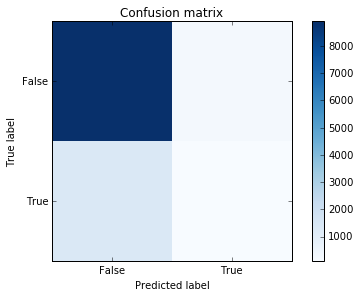

In [179]:
## Model 1
# Compute confusion matrix
cm = confusion_matrix(Y_respon_val, prediction['Logistic_q3'])
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

Confusion matrix, with normalization
[[ 0.97  0.03]
 [ 0.92  0.08]]


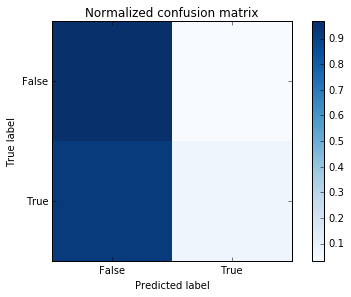

In [180]:
# Compute normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Confusion matrix, with normalization')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

Confusion matrix, without normalization
[[6666 2545]
 [ 855  612]]


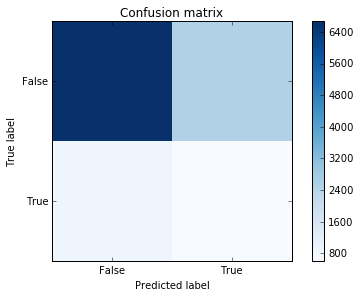

In [181]:
## Model 2
# Compute confusion matrix
cm = confusion_matrix(Y_respon_val, prediction['Logistic_bal_q3'])
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

Confusion matrix, with normalization
[[ 0.72  0.28]
 [ 0.58  0.42]]


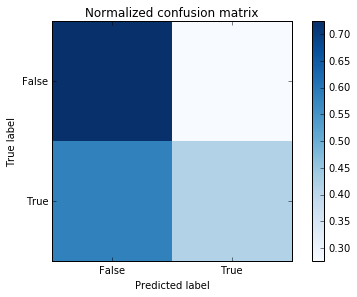

In [182]:
# Compute normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Confusion matrix, with normalization')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

Confusion matrix, without normalization
[[8902  309]
 [1356  111]]


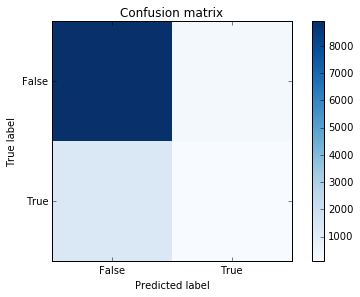

In [183]:
## Model 3
# Compute confusion matrix
cm = confusion_matrix(Y_respon_val, prediction['Logistic_lasso_q3'])
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

Confusion matrix, with normalization
[[ 0.97  0.03]
 [ 0.92  0.08]]


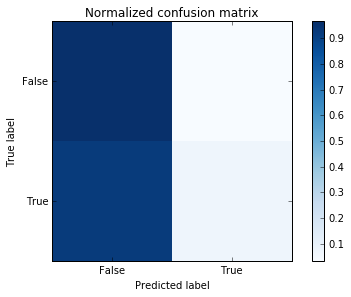

In [184]:
# Compute normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Confusion matrix, with normalization')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

Confusion matrix, without normalization
[[8902  309]
 [1356  111]]


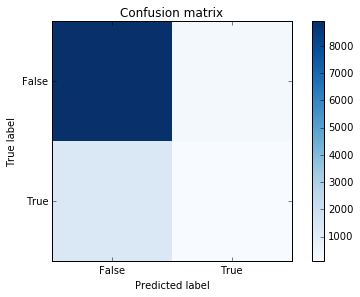

In [185]:
## Model 4
# Compute confusion matrix
cm = confusion_matrix(Y_respon_val, prediction['Logistic_lasso_bal_q3'])
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

Confusion matrix, with normalization
[[ 0.97  0.03]
 [ 0.92  0.08]]


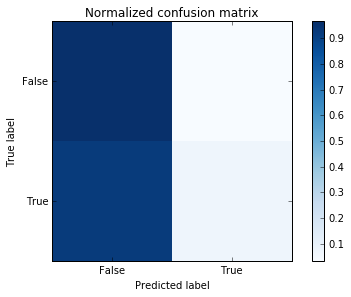

In [186]:
# Compute normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Confusion matrix, with normalization')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

Confusion matrix, without normalization
[[9206    5]
 [1464    3]]


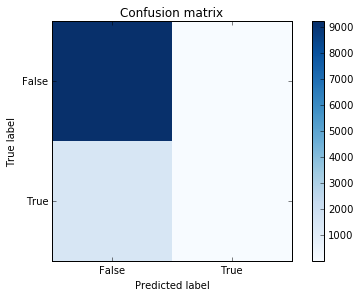

In [187]:
## Model 5
# Compute confusion matrix
cm = confusion_matrix(Y_respon_val, prediction['Random_Forest_q3'])
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

Confusion matrix, with normalization
[[  9.99e-01   5.43e-04]
 [  9.98e-01   2.04e-03]]


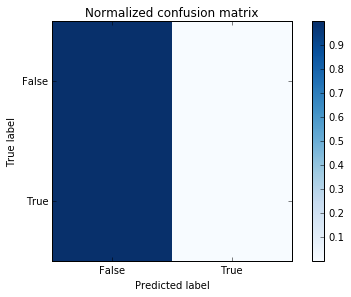

In [188]:
# Compute normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Confusion matrix, with normalization')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

Confusion matrix, without normalization
[[6797 2414]
 [ 818  649]]


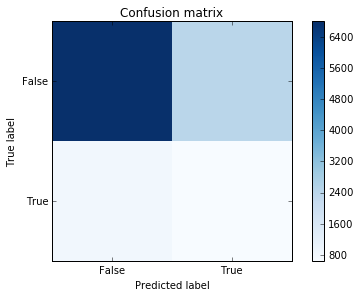

In [189]:
## Model 6
# Compute confusion matrix
cm = confusion_matrix(Y_respon_val, prediction['Random_Forest_bal_q3'])
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

Confusion matrix, with normalization
[[ 0.74  0.26]
 [ 0.56  0.44]]


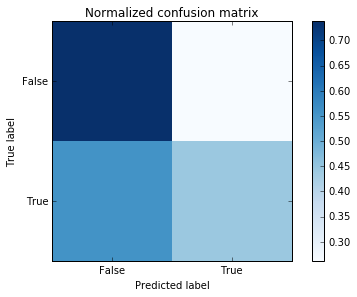

In [190]:
# Compute normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Confusion matrix, with normalization')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

Confusion matrix, without normalization
[[8270  941]
 [1319  148]]


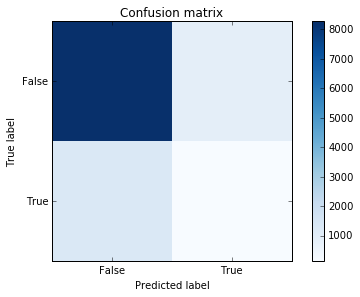

In [191]:
## Model 7
# Compute confusion matrix
cm = confusion_matrix(Y_respon_val, prediction['test'])
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

Confusion matrix, with normalization
[[ 0.9  0.1]
 [ 0.9  0.1]]


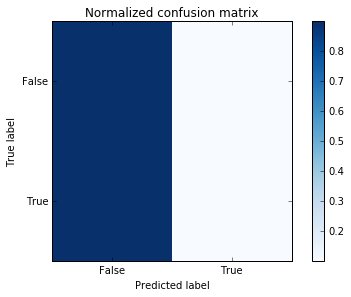

In [192]:
# Compute normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Confusion matrix, with normalization')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

#### Conclusion: I select Model 5 - unbalanced Random Forest

## Further Improvements

1. Use Cross-Validation method to calculate the optimal tuning parameters for Logistic regression and Random Forest.
2. Replace Term-document matrix with LDA as predictors to reduce the dimension.
3. Deal with imbalanced samples: use downsampling (sample one or a few elements of class 'True' for each element of class 'False') and upsampling (duplicate elements in class 'True') to manipulate the training set.
4. More deep analysis: Variable Important Plot, Partial Dependence Plot